# CytoTRACEKernel validation

Use diverse datasets to validate the CytoTRACE reimplementation in CellRank 2. 

# Preliminaries

## Dependecy notebooks

This notebook depends on the following notebooks: 

- Tabula muris bone marrow (10x): [ML-2023-07-17_tabula_muris_bone_marrow_10x_prep.ipynb](ML-2023-07-17_tabula_muris_bone_marrow_10x_prep.ipynb)
- Tabula muris bone marrow (SmartSeq2): [ML-2023-07-17_tabula_muris_bone_marrow_smartseq2_prep.ipynb](ML-2023-07-17_tabula_muris_bone_marrow_smartseq2_prep.ipynb)
- C. elegans (Cilitated neurons): [ML-2023-07-17_ciliated_neurons_prep.ipynb](ML-2023-07-17_ciliated_neurons_prep.ipynb)
- C. elegans (Muscle and mesoderm): [ML-2023-07-17_muscle_and_mesoderm_prep.ipynb](ML-2023-07-17_muscle_and_mesoderm_prep.ipynb)
- C. elegans (Hypodermis and seam): [ML-2021-07-17_hypodermis_and_seam_prep.ipynb](ML-2021-07-17_hypodermis_and_seam_prep.ipynb)
- Zebrafish: [ML-2023-07-17_zebrafish_prep.ipynb](ML-2023-07-17_zebrafish_prep.ipynb)

## Library imports

In [1]:
%load_ext autoreload
%autoreload 2

Import packages

In [2]:
# import standard packages
import numpy as np
import pandas as pd 
import seaborn as sns
from scipy.sparse import csr_matrix
from scipy.stats import spearmanr, kendalltau
import matplotlib.pyplot as plt
import sys
import os

# import single-cell packages
import scanpy as sc
import scvelo as scv
from anndata import AnnData

import cellrank as cr
from cellrank.kernels import CytoTRACEKernel
from cellrank._utils._utils import _correlation_test_helper

## Set up paths

In [3]:
sys.path.extend(["../../../", "."])
from paths import DATA_DIR, FIG_DIR  # isort: skip  # noqa: E402

# adjust directories
DATA_DIR = DATA_DIR / "cytotrace_kernel" / "validation"
FIG_DIR = FIG_DIR / "cytotrace_kernel" / "validation"

scv.settings.figdir = str(FIG_DIR)
sc.settings.figdir = str(FIG_DIR)
cr.settings.figdir = str(FIG_DIR)

## Print package versions for reproducibility

In [4]:
cr.logging.print_versions()
cr.logging.print_version_and_date()

cellrank==1.5.2.dev241+gb16a7688.d20230718 scanpy==1.9.3 anndata==0.9.1 numpy==1.24.4 numba==0.57.1 scipy==1.11.1 pandas==2.0.3 pygpcca==1.0.4 scikit-learn==1.1.3 statsmodels==0.14.0 scvelo==0.3.0 pygam==0.8.0 matplotlib==3.7.2 seaborn==0.12.2
Running CellRank 1.5.2.dev241+gb16a7688.d20230718, on 2023-07-18 18:42.


## General settings

In [5]:
sc.settings.verbosity = 2
cr.settings.verbosity = 4
scv.settings.verbosity = 3

In [6]:
scv.settings.set_figure_params("scvelo", dpi_save=400, dpi=80, transparent=True, 
                               fontsize=20, color_map="viridis")
scv.settings.plot_prefix = ""

In [7]:
SAVE_FIGURES = True
if SAVE_FIGURES:
    os.makedirs(FIG_DIR, exist_ok=True)

## Utility functions

In [8]:
def quantify_agreement(adata: AnnData,
                       ground_truth_maturity: dict, 
                       cyto_trace_key: str = 'ct_pseudotime', 
                       groupby: str = 'clusters', 
                       use_kendalltau: bool = False):
    """Quantify agreement between cyto_trace maturity score and ground-truth
    
    Parameters
    ---
    ground_truth_maturity
        Dict of `cluster: maturity`
    cyto_trace_key
        Key from `adata.obs` where cyto_trace score assesing maturity can be found. 
        Higher values shoudl correspond to more mature cell types (i.e. like a pseudotime)
    groupby
        Denotes where to find the categorical group annotation that should be used to average the
        cyto-trace score
    use_kendalltau
        If true, use `scipy.stats.kendalltau`, else use `scipy.states.spearmanr`
        
    Returns
    ---
        Results of the association test
    """
    
    # get the average cyto-trace score
    clusters = adata.obs[groupby].cat.categories
    cyto_trace_maturity = {cl: np.mean(adata[adata.obs[groupby] == cl].obs[cyto_trace_key]) for cl in clusters}

    # put both as columns in a dataframe
    maturity_df = pd.DataFrame.from_dict(ground_truth_maturity, orient='index', columns=['gt'])
    maturity_df['cyto_trace'] = maturity_df.index.map(cyto_trace_maturity)

    # compute association
    result =  kendalltau(maturity_df['gt'], maturity_df['cyto_trace'])  if use_kendalltau else spearmanr(maturity_df['gt'], maturity_df['cyto_trace']) 

    return result

In [9]:
def compute_consistency(validation_data: dict):
    """Show scatter plot of original vs. re-implementation. 
    
    Parameters
    --------
    validation_data_work
        data_work sets where the comparison is to be performed
        
    Returns
    --------
    results: contains the comparison as a DataFrame
    scores: the computed CytoTRACE scores
    """
    
    # create dataframe for the results (the actual comparison scores)
    results = pd.DataFrame(index=validation_data.keys(), columns=['sp_corr_new', 'sp_corr_old', 'pe_corr'])
    
    # create a dict for the computed CytoTRACE scores
    scores = {}
    
    # loop over data_worksets
    for key, data in validation_data.items():
        
        print(f"\nProcessing {key}\n")
        
        # make a copy of the object
        data_work = data.copy()
        
        # sparsify the data_work object
        sparse_X = csr_matrix(data_work.X)
        data_work.X = sparse_X
        
        # filter genes
        sc.pp.filter_genes(data_work, min_cells=10)
        data_work.raw = data_work.copy()

        # normalize and log transform
        scv.pp.normalize_per_cell(data_work)
        sc.pp.log1p(data_work)

        # Annotate (but do not filter to) highly variable genes
        sc.pp.highly_variable_genes(data_work)
        print(f"This detected {np.sum(data_work.var['highly_variable'])} highly variable genes. ")

        # Compute PCA, neighbors and moments
        sc.tl.pca(data_work)
        sc.pp.neighbors(data_work, n_pcs=30, n_neighbors=30)

        # Need to use a hack here - moments likes to impute values in a spliced layer, so we have to create that. 
        data_work.layers['spliced'] = data_work.X
        data_work.layers['unspliced'] = data_work.X

        scv.pp.moments(data_work, n_pcs=None, n_neighbors=None)

        # Check that we have in fact computed imputed expression values for all (not just hv) genes
        assert(data_work.layers['Ms'].shape[1] == data_work.X.shape[1]), "Imputed shape does not match raw shape"
        
        # instantiate a CytoTRACE kernel from cellrank and compute the CytoTRACE score
        ctk = CytoTRACEKernel(data_work).compute_cytotrace()
        
        # create a dict that stores the ground truth per cluster
        diff_state_gt = {cat: i for i, cat in enumerate(data_work.obs['Ground_truth'].cat.categories)}

        # Quantify agreement between reimplementation and ground truth
        sp_corr_new = quantify_agreement(data_work, ground_truth_maturity=diff_state_gt, groupby="Ground_truth", 
                           cyto_trace_key="ct_pseudotime")

       #  Quantify agreement between original implementation and ground truth
        sp_corr_old = quantify_agreement(data_work, ground_truth_maturity=diff_state_gt, groupby="Ground_truth", 
                           cyto_trace_key='original_ct_pseudotime')
        
        # Quantify correlation among the two measures
        pe_corr = np.corrcoef(x=data_work.obs['ct_pseudotime'], y=data_work.obs['original_ct_pseudotime'])[0, 1]
        
        # write to the results data_Frame
        results.loc[key, 'sp_corr_new'] = sp_corr_new.correlation
        results.loc[key, 'sp_corr_old'] = sp_corr_old.correlation
        results.loc[key, 'pe_corr'] = pe_corr
        scores[key] = data_work.obs['ct_pseudotime']
        
    return results, scores

## Load all data

Load all validation data sets

In [10]:
validation_data = {}

Bone marrow 10x

In [11]:
adata = sc.read(DATA_DIR / "tabula_muris" / "ML-2023-07-17_bone_marrow_10x_merged.h5ad")
validation_data['Bone marrow 10x (Schaum et al., Nature 2018)'] = adata
adata

AnnData object with n_obs × n_vars = 3427 × 13526
    obs: 'Phenotype', 'Ground_truth', 'Component_1', 'Component_2', 'CytoTRACE', 'original_ct_pseudotime', 'Ground_truth_cont'
    uns: 'Ground_truth_colors', 'Phenotype_colors'
    obsm: 'X_ct'

Bone marrow smartseq2

In [12]:
adata = sc.read(DATA_DIR / "tabula_muris" / "ML-2023-07-17_bone_marrow_smartseq2_merged.h5ad")
validation_data['Bone marrow SmartSeq2 (Schaum et al., Nature 2018)'] = adata
adata

AnnData object with n_obs × n_vars = 4442 × 17479
    obs: 'Phenotype', 'Ground_truth', 'Component_1', 'Component_2', 'CytoTRACE', 'original_ct_pseudotime', 'Ground_truth_cont'
    uns: 'Ground_truth_colors', 'Phenotype_colors'
    obsm: 'X_ct'

C. elegans hypodermis and seam

In [13]:
adata = sc.read(DATA_DIR / "c_elegans" / "ML-2023-07-17_hypodermis_and_seam_merged.h5ad")
validation_data['C. elegans hypodermis and seam (Packer et al., Science 2019)'] = adata
adata

AnnData object with n_obs × n_vars = 12254 × 20222
    obs: 'Phenotype', 'Ground_truth', 'Component_1', 'Component_2', 'CytoTRACE', 'original_ct_pseudotime', 'Ground_truth_cont'
    uns: 'Ground_truth_colors', 'Phenotype_colors'
    obsm: 'X_ct'

C. elegans muscle and mesoderm

In [14]:
adata = sc.read(DATA_DIR / "c_elegans" / "ML-2023-07-17_muscle_and_mesoderm_merged.h5ad")
validation_data['C. elegans muscle and mesoderm (Packer et al., Science 2019)'] = adata
adata

AnnData object with n_obs × n_vars = 22370 × 20222
    obs: 'Phenotype', 'Ground_truth', 'Component_1', 'Component_2', 'CytoTRACE', 'original_ct_pseudotime', 'Ground_truth_cont'
    uns: 'Ground_truth_colors', 'Phenotype_colors'
    obsm: 'X_ct'

C. elegans ciliated neurons

In [15]:
adata = sc.read(DATA_DIR / "c_elegans" / "ML-2023-07-17_ciliated_neurons_merged.h5ad")
validation_data['C. elegans ciliated neurons (Packer et al., Science 2019)'] = adata
adata

AnnData object with n_obs × n_vars = 10775 × 20222
    obs: 'Phenotype', 'Ground_truth', 'CytoTRACE', 'cell.type', 'cell.subtype', 'original_ct_pseudotime', 'Ground_truth_cont', 'gt_terminal_states'
    uns: 'Ground_truth_colors', 'Phenotype_colors', 'gt_terminal_states_colors'
    obsm: 'X_ct'

Zebrafish embryogenesis

In [16]:
adata = sc.read(DATA_DIR / "zebrafish" / "ML-2023-07-17_zebrafish_merged.h5ad")
adata.obs['Ground_truth'] = adata.obs['ct_ground_truth']

validation_data['Zebrafish embryogenesis (Farrell et al., Science 2018)'] = adata
adata

AnnData object with n_obs × n_vars = 38731 × 23974
    obs: 'Stage', 'Lineage_Spinal_Cord', 'Lineage_Diencephalon', 'Lineage_Optic_Cup', 'Lineage_Midbrain_Neural_Crest', 'Lineage_Hindbrain_R3', 'Lineage_Hindbrain_R4_5_6', 'Lineage_Telencephalon', 'Lineage_Epidermis', 'Lineage_Neural_Plate_Border', 'Lineage_Placode_Adeno._Lens_Trigeminal', 'Lineage_Placode_Epibranchial_Otic', 'Lineage_Placode_Olfactory', 'Lineage_Tailbud', 'Lineage_Adaxial_Cells', 'Lineage_Somites', 'Lineage_Hematopoeitic_ICM', 'Lineage_Hematopoeitic_RBI_Pronephros', 'Lineage_Endoderm_Pharyngeal', 'Lineage_Endoderm_Pancreatic_Intestinal', 'Lineage_Heart_Primordium', 'Lineage_Cephalic_Mesoderm', 'Lineage_Prechordal_Plate', 'Lineage_Notochord', 'Lineage_Primordial_Germ_Cells', 'Lineage_EVL', 'ct_phenotype', 'ct_ground_truth', 'ct_score', 'gt_terminal_states', 'original_ct_pseudotime', 'ct_ground_truth_cont', 'Ground_truth'
    uns: 'Lineage_Adaxial_Cells_colors', 'Lineage_Cephalic_Mesoderm_colors', 'Lineage_Diencephalon_c

# Compare across datasets

In [17]:
df_results, scores = compute_consistency(validation_data)


Processing Bone marrow 10x (Schaum et al., Nature 2018)

filtered out 923 genes that are detected in less than 10 cells
Normalized count data: X.
extracting highly variable genes
    finished (0:00:00)
This detected 1878 highly variable genes. 
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 30


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished (0:00:03)
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Computing CytoTRACE score with `12603` genes
DEBUG: Correlating all genes with number of genes expressed per cell
Adding `adata.obs['ct_score']`
       `adata.obs['ct_pseudotime']`
       `adata.obs['ct_num_exp_genes']`
       `adata.var['ct_gene_corr']`
       `adata.var['ct_correlates']`
       `adata.uns['ct_params']`
    Finish (0:00:00)

Processing Bone marrow SmartSeq2 (Schaum et al., Nature 2018)

filtered out 1589 genes that are detected in less than 10 cells
Normalized count data: X.
extracting highly variable genes
    finished (0:00:00)
This detected 3249 highly variable genes. 
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:00)
computing moments based on connectivities
    finished (0:00:03) --> added

In [18]:
df_results

,sp_corr_new,sp_corr_old,pe_corr
"Bone marrow 10x (Schaum et al., Nature 2018)",0.8,0.8,0.950974
"Bone marrow SmartSeq2 (Schaum et al., Nature 2018)",1.0,1.0,0.854518
"C. elegans hypodermis and seam (Packer et al., Science 2019)",0.715351,0.710496,0.92608
"C. elegans muscle and mesoderm (Packer et al., Science 2019)",0.944974,0.94403,0.940743
"C. elegans ciliated neurons (Packer et al., Science 2019)",0.942422,0.952583,0.972501
"Zebrafish embryogenesis (Farrell et al., Science 2018)",0.993007,0.986014,0.915976


Add a column for the label. 

In [19]:
df_results['label'] = [f"{name}: {np.round(corr, 2)}" for name, corr in zip(df_results.index, df_results['pe_corr'])]
df_results['label'] = pd.Series(df_results['label'], dtype='category')

Show the results in a scatter plot. 

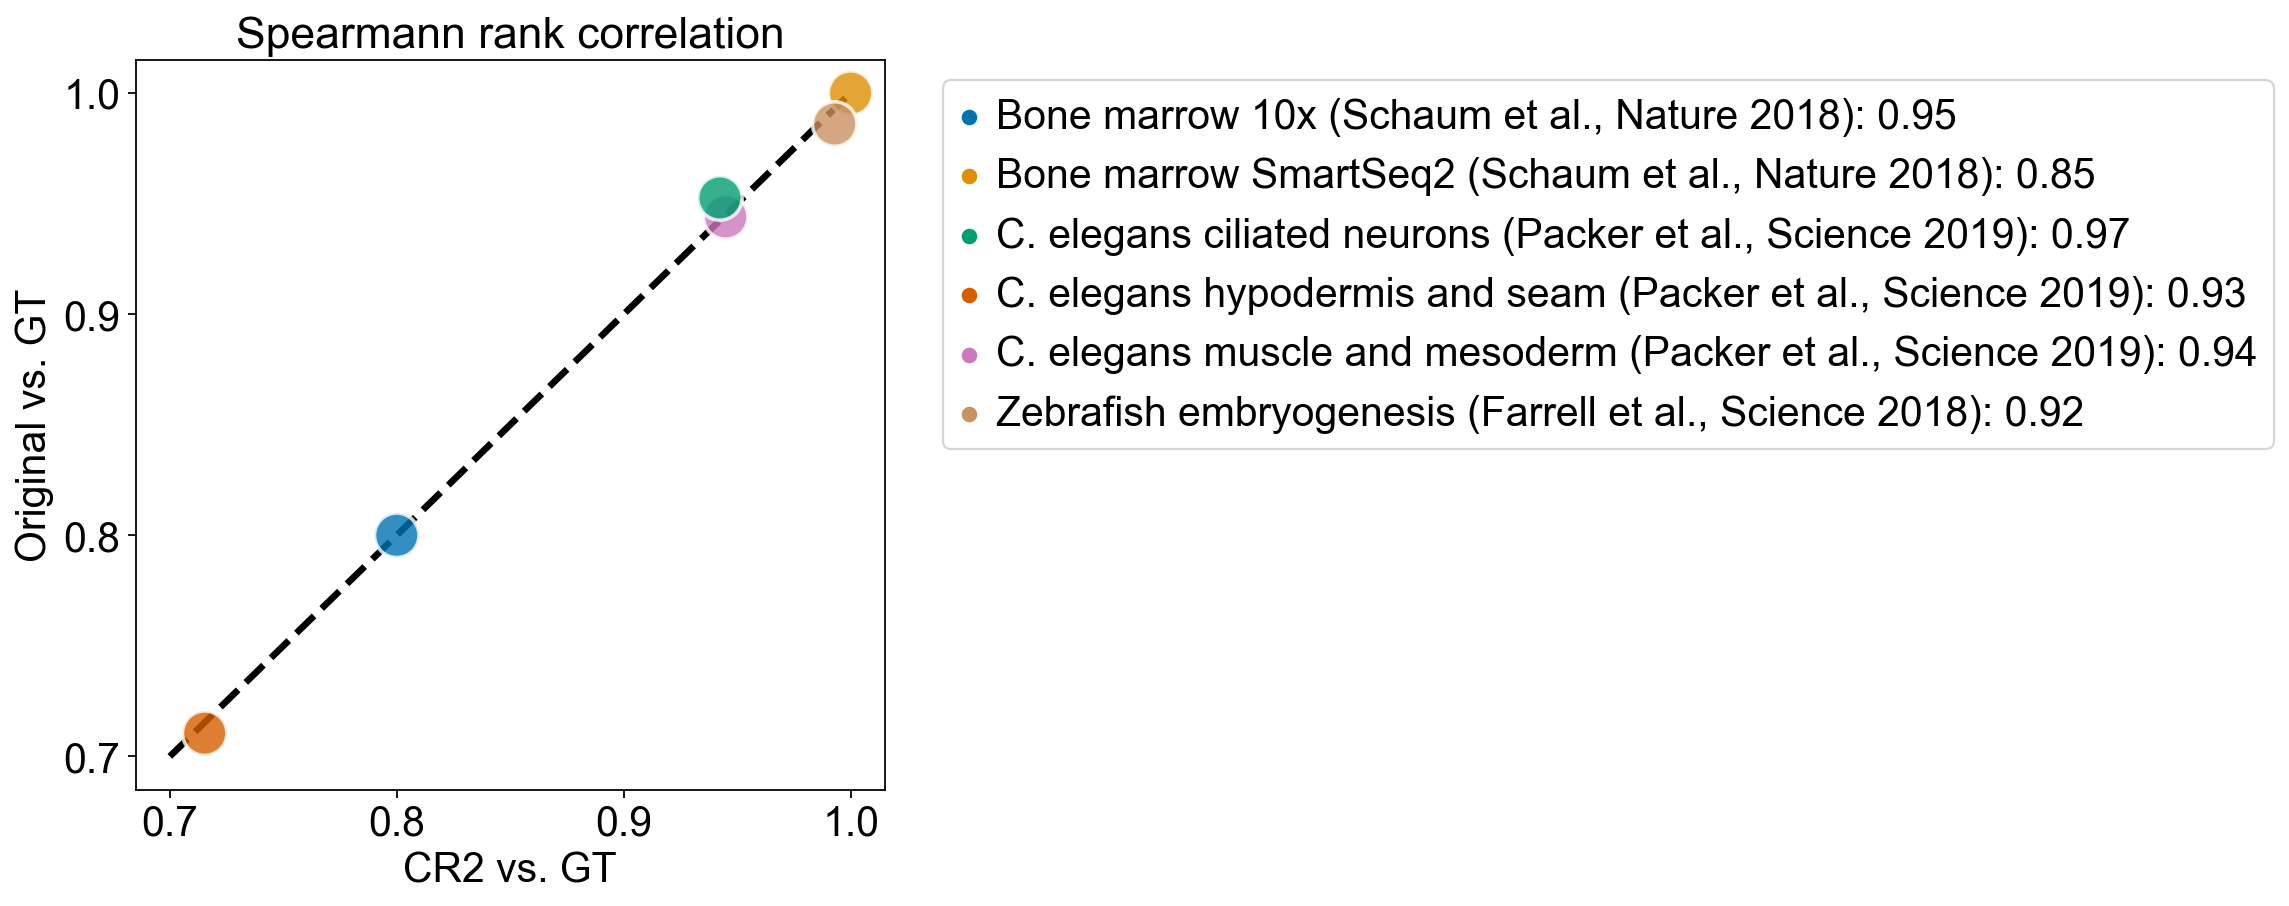

In [20]:
plt.figure(figsize=(6, 6))
ax_min, ax_max = 0.7, 1.0
ticks = np.arange(ax_min, ax_max, 0.1)

# Set the colorblind-friendly color palette
color_palette = sns.color_palette('colorblind', n_colors=df_results.shape[0])

# Create a scatter plot with labeled points
scatter_plot = sns.scatterplot(data=df_results, x='sp_corr_new', y='sp_corr_old', 
                               hue='label', s=400, alpha=0.8, palette=color_palette)

# Move the legend outside the plot
scatter_plot.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add a diagonal dashed line
plt.plot([ax_min,ax_max], [ax_min, ax_max], "k--", zorder=-100, linewidth=3)

# Add labels, title and ticks
plt.xlabel('CR2 vs. GT')
plt.ylabel('Original vs. GT')
plt.xticks(ticks)
plt.yticks(ticks)
plt.title('Spearmann rank correlation')

# Display the plot
if SAVE_FIGURES:
    plt.savefig(
        FIG_DIR / "comparison.pdf",
        format="pdf",
        transparent=True,
        bbox_inches="tight",
    )

plt.show()

# Focus on C. elegans muscle and mesoderm

In [21]:
data_key = 'C. elegans muscle and mesoderm (Packer et al., Science 2019)'
bdata = validation_data[data_key]
bdata.obs['CR2_ct_pseudotime'] = scores[data_key]
bdata

AnnData object with n_obs × n_vars = 22370 × 20222
    obs: 'Phenotype', 'Ground_truth', 'Component_1', 'Component_2', 'CytoTRACE', 'original_ct_pseudotime', 'Ground_truth_cont', 'CR2_ct_pseudotime'
    uns: 'Ground_truth_colors', 'Phenotype_colors'
    obsm: 'X_ct'

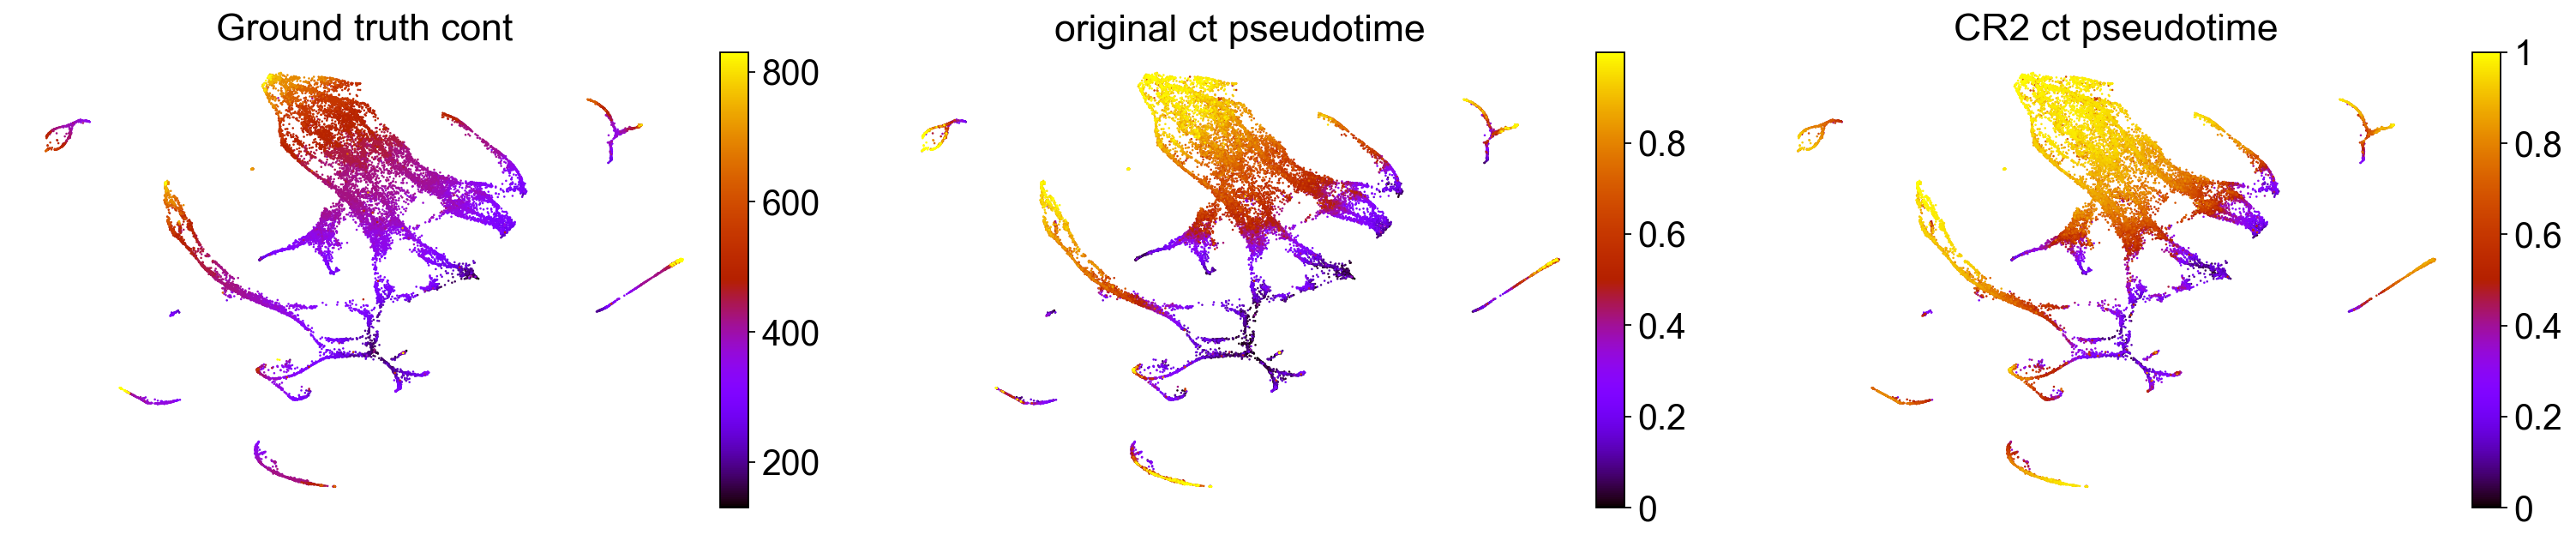

In [28]:
fig_kwargs = {
    "basis":"ct", 
    "color": ['Ground_truth_cont', 'original_ct_pseudotime', 'CR2_ct_pseudotime'], 
    "color_map": 'gnuplot', 
    "frameon": False}

if SAVE_FIGURES:
    fig_kwargs["save"] = "c_elegans_example.pdf"

sc.pl.scatter(bdata, **fig_kwargs)